# 🚀 Spaceship Titanic - 完全学習ガイド（グラフ付き）
## 📌 このノートブックについて
Kaggle「Spaceship Titanic」コンペティションで**0.805を達成**した手法を、
**豊富なグラフと可視化**で学習用にまとめたものです。
---
## 🎯 達成した結果
| バージョン | Kaggleスコア | 特徴量数 |
|-----------|-------------|------|----------|
| 基本版 | 0.80336 |  | 38 |
| **最適化版** | **0.80523** | **** | 50 |
---
## 📊 このノートブックの特徴
### ✅ 含まれるグラフ
1. ターゲット変数の分布（棒グラフ・円グラフ）
2. カテゴリカル変数とTransportedの関係
3. 数値変数の分布（ヒストグラム重ね合わせ）
4. 総支出額とTransportedの関係
5. Cabin（デッキ・サイド）の分析
6. 数値変数の相関行列（ヒートマップ）
7. グループサイズの分布と転送率
8. 年齢グループごとの転送率
9. 特徴量の重要度（トップ20）
10. モデル性能の比較
### 📚 学べること
- データの理解（EDA）
- 特徴量エンジニアリング
- グループ情報の活用法
- 欠損値の賢い処理
- 複数モデルの構築と比較
- アンサンブル手法
---

## 1️⃣ ライブラリのインポート
必要なライブラリをインポートします。

In [1]:
# 日本語フォントのインストール（最初に実行）
!pip install japanize-matplotlib -q

# データ処理
import pandas as pd
import numpy as np

# 可視化
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib  # 日本語フォント対応

# 機械学習
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# XGBoostとLightGBMのインストールと読み込み
try:
    import xgboost as xgb
except:
    import subprocess
    subprocess.check_call(['pip', 'install', 'xgboost', '--break-system-packages'])
    import xgboost as xgb

try:
    import lightgbm as lgb
except:
    import subprocess
    subprocess.check_call(['pip', 'install', 'lightgbm', '--break-system-packages'])
    import lightgbm as lgb

# 警告の非表示
import warnings
warnings.filterwarnings('ignore')

# スタイル設定
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 【重要】Seabornのフォント設定（日本語文字化け対策）
sns.set(font='IPAexGothic')

# ランダムシード固定（再現性のため）
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ ライブラリのインポート完了！")
print("✅ 日本語フォント設定完了！")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 71.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
✅ ライブラリのインポート完了！
✅ 日本語フォント設定完了！


## 2️⃣ データの読み込み

In [2]:
# データの読み込み
train_df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
sample_submission = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')

print(f"訓練データのサイズ: {train_df.shape}")
print(f"テストデータのサイズ: {test_df.shape}")

# 元データのコピーを保存
train_original = train_df.copy()
test_original = test_df.copy()

訓練データのサイズ: (8693, 14)
テストデータのサイズ: (4277, 13)


## 3️⃣ データの基本情報確認
### 3.1 最初の数行を確認

In [3]:
train_df.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


### 3.2 データの型と欠損値の確認

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
# 欠損値の割合を確認
missing_train = pd.DataFrame({
    '欠損数': train_df.isnull().sum(),
    '欠損率(%)': (train_df.isnull().sum() / len(train_df)) * 100
})
missing_train = missing_train[missing_train['欠損数'] > 0].sort_values('欠損率(%)', ascending=False)
print("\n【訓練データの欠損値】")
print(missing_train)


【訓練データの欠損値】
              欠損数    欠損率(%)
CryoSleep     217  2.496261
ShoppingMall  208  2.392730
VIP           203  2.335212
HomePlanet    201  2.312205
Name          200  2.300702
Cabin         199  2.289198
VRDeck        188  2.162660
FoodCourt     183  2.105142
Spa           183  2.105142
Destination   182  2.093639
RoomService   181  2.082135
Age           179  2.059128


### 3.3 統計情報の確認

In [6]:
train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


### 3.4 ターゲット変数の分布

【Transported（異次元転送）の分布】
Transported
True     4378
False    4315
Name: count, dtype: int64

転送された割合: 50.36%


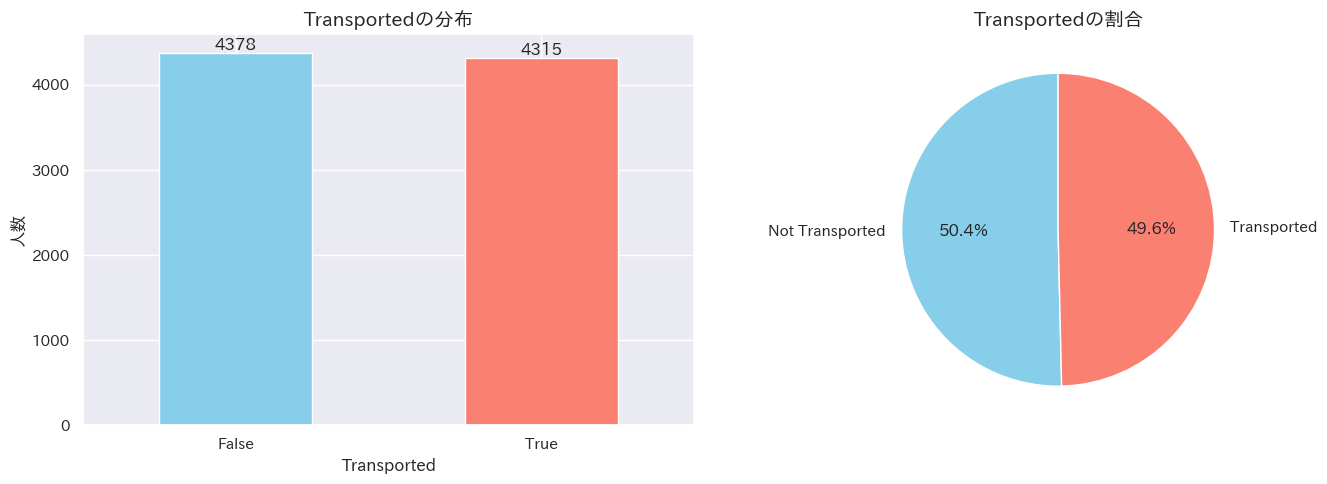

In [7]:
# Transportedの分布
transported_counts = train_df['Transported'].value_counts()
print("【Transported（異次元転送）の分布】")
print(transported_counts)
print(f"\n転送された割合: {transported_counts[True] / len(train_df) * 100:.2f}%")

# 可視化
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
transported_counts.plot(kind='bar', ax=ax[0], color=['skyblue', 'salmon'])
ax[0].set_title('Transportedの分布', fontsize=14, weight='bold')
ax[0].set_xlabel('Transported')
ax[0].set_ylabel('人数')
ax[0].set_xticklabels(['False', 'True'], rotation=0)
for container in ax[0].containers:
    ax[0].bar_label(container)

ax[1].pie(transported_counts, labels=['Not Transported', 'Transported'], 
          autopct='%1.1f%%', colors=['skyblue', 'salmon'], startangle=90)
ax[1].set_title('Transportedの割合', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

## 4️⃣ 基本的な特徴量抽出
データから追加の情報を抽出します。

In [8]:
def extract_basic_features(df):
    """
    PassengerId、Cabin、Nameから基本的な特徴量を抽出
    """
    # PassengerIdは "gggg_pp" の形式
    # gggg: グループID、pp: グループ内の番号
    df['GroupId'] = df['PassengerId'].apply(lambda x: x.split('_')[0])
    df['GroupNum'] = df['PassengerId'].apply(lambda x: int(x.split('_')[1]))
    
    # Cabinは "deck/num/side" の形式
    # 例: "B/0/P" -> Deck:B, Num:0, Side:P
    df['Cabin_Deck'] = df['Cabin'].apply(lambda x: x.split('/')[0] if pd.notna(x) else np.nan)
    df['Cabin_Num'] = df['Cabin'].apply(lambda x: int(x.split('/')[1]) if pd.notna(x) else np.nan)
    df['Cabin_Side'] = df['Cabin'].apply(lambda x: x.split('/')[2] if pd.notna(x) else np.nan)
    
    # Nameから姓と名を分離
    df['FirstName'] = df['Name'].apply(lambda x: x.split()[0] if pd.notna(x) else np.nan)
    df['LastName'] = df['Name'].apply(lambda x: x.split()[1] if pd.notna(x) and len(x.split()) > 1 else np.nan)
    
    # 支出項目の合計
    spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df['TotalSpending'] = df[spending_cols].sum(axis=1)
    
    return df

train_df = extract_basic_features(train_df)
test_df = extract_basic_features(test_df)

print("✅ 基本的な特徴量抽出完了")
print(f"\n新しい特徴量: GroupId, GroupNum, Cabin_Deck, Cabin_Num, Cabin_Side, FirstName, LastName, TotalSpending")

✅ 基本的な特徴量抽出完了

新しい特徴量: GroupId, GroupNum, Cabin_Deck, Cabin_Num, Cabin_Side, FirstName, LastName, TotalSpending


## 5️⃣ 探索的データ分析（EDA）
### 5.1 カテゴリカル変数とターゲットの関係

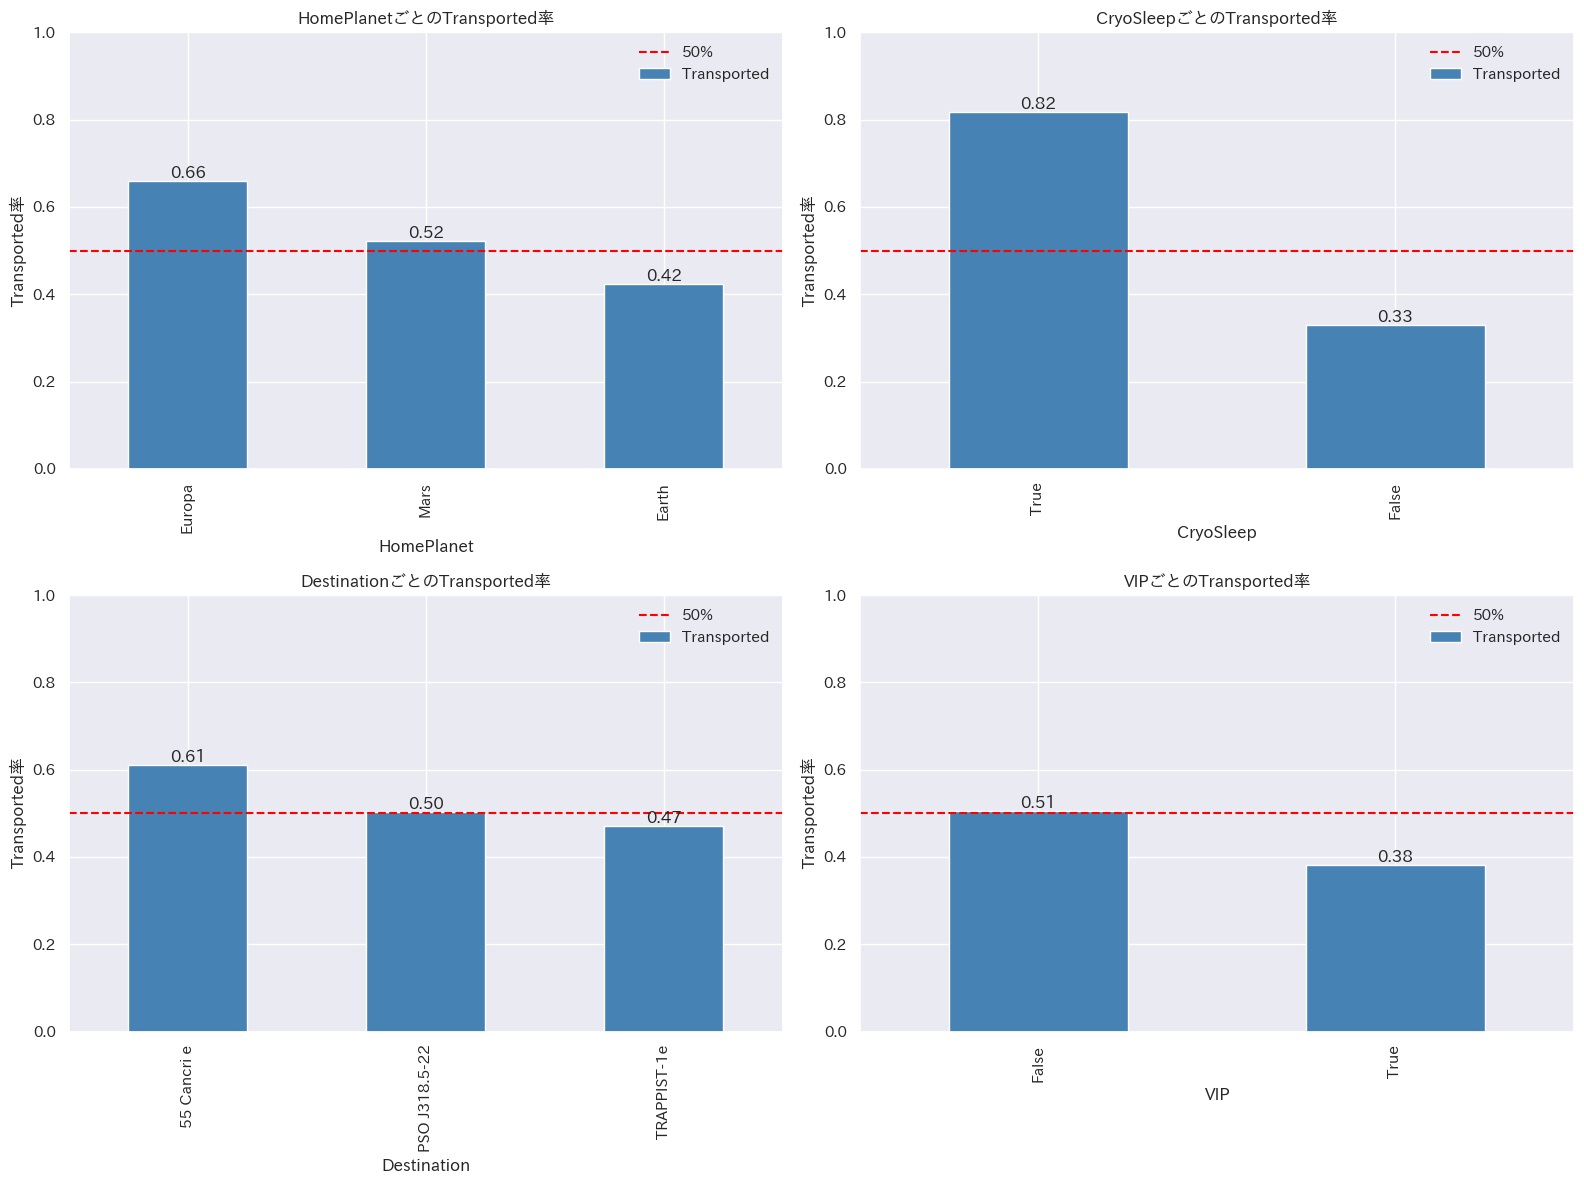

In [9]:
# カテゴリカル変数のリスト
categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    # 各カテゴリごとのTransported率
    transported_rate = train_df.groupby(col)['Transported'].mean().sort_values(ascending=False)
    transported_rate.plot(kind='bar', ax=axes[idx], color='steelblue')
    axes[idx].set_title(f'{col}ごとのTransported率', fontsize=12, weight='bold')
    axes[idx].set_ylabel('Transported率')
    axes[idx].set_ylim([0, 1])
    axes[idx].axhline(y=0.5, color='red', linestyle='--', label='50%')
    axes[idx].legend()
    
    # 各バーの上に数値を表示
    for container in axes[idx].containers:
        axes[idx].bar_label(container, fmt='%.2f')

plt.tight_layout()
plt.show()

**観察ポイント**:
- CryoSleepがTrueの人は転送率が非常に高い
- HomePlanetやDestinationによっても転送率が異なる
- VIPステータスも影響がある可能性

### 5.2 数値変数の分布

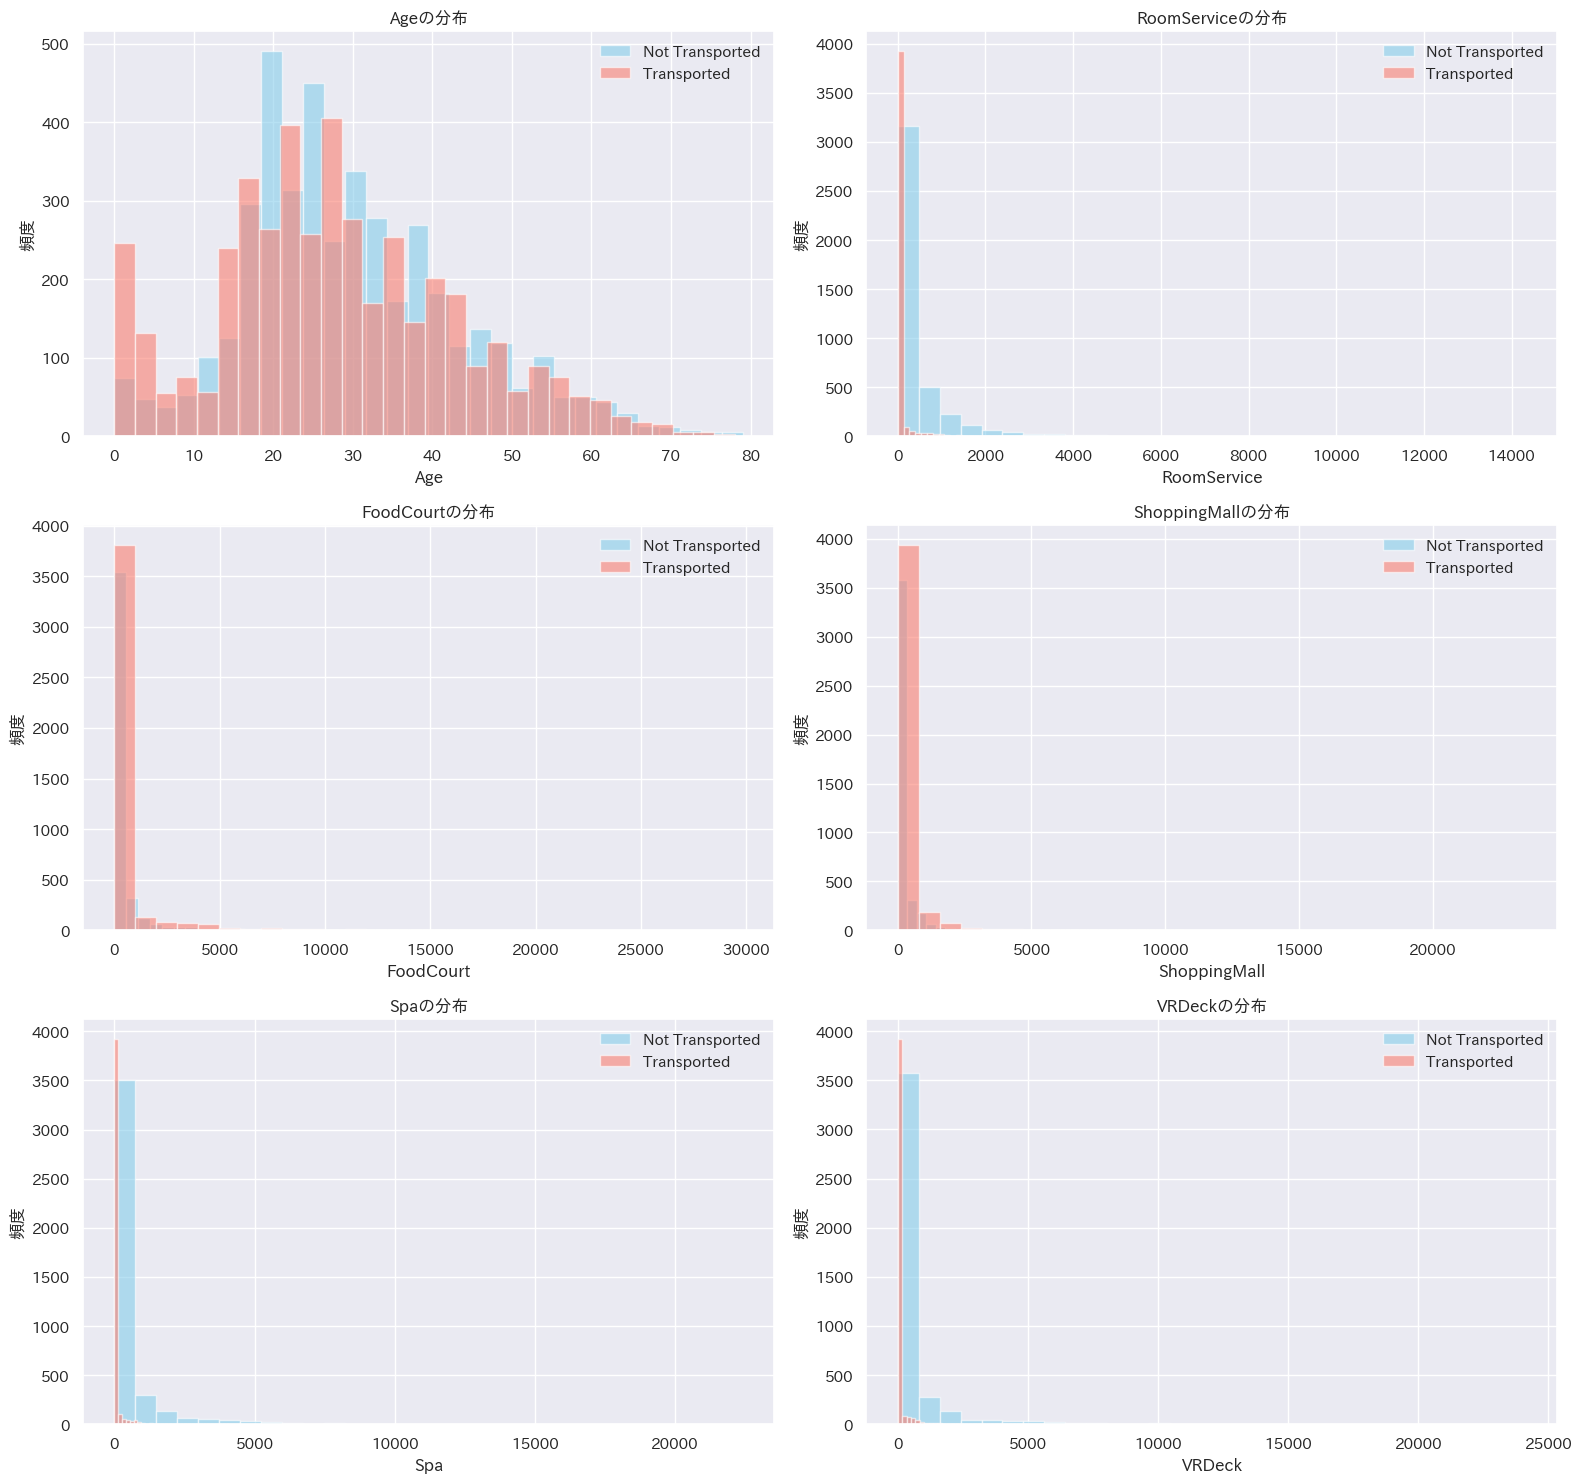

In [10]:
# 数値変数のリスト
numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

fig, axes = plt.subplots(3, 2, figsize=(16, 15))
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    # Transportedごとのヒストグラム
    train_df[train_df['Transported'] == False][col].hist(ax=axes[idx], alpha=0.6, 
                                                           bins=30, label='Not Transported', color='skyblue')
    train_df[train_df['Transported'] == True][col].hist(ax=axes[idx], alpha=0.6, 
                                                          bins=30, label='Transported', color='salmon')
    axes[idx].set_title(f'{col}の分布', fontsize=12, weight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('頻度')
    axes[idx].legend()

plt.tight_layout()
plt.show()

**観察ポイント**:
- 多くの人が各施設で0円しか使っていない（CryoSleep中の可能性）
- 転送された人は支出が少ない傾向

### 5.3 総支出額とTransportedの関係

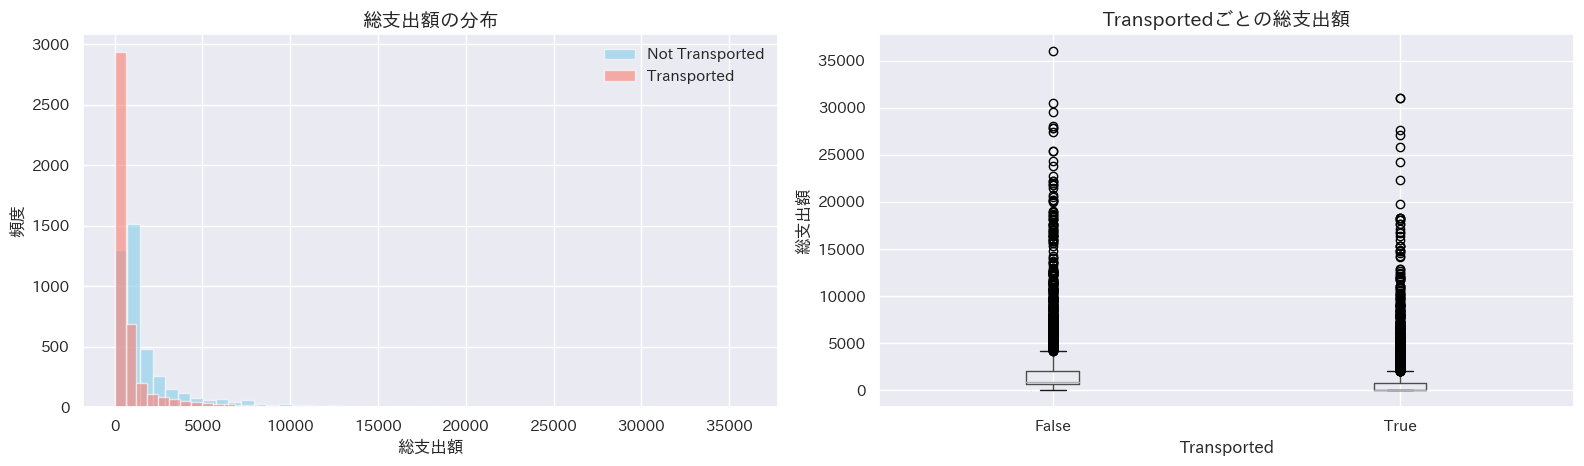


【総支出額の統計】
Not Transportedの平均: 2004.15
Transportedの平均: 885.69


In [11]:
# TotalSpendingとTransportedの関係
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

train_df[train_df['Transported'] == False]['TotalSpending'].hist(ax=ax[0], alpha=0.6, 
                                                                   bins=50, label='Not Transported', color='skyblue')
train_df[train_df['Transported'] == True]['TotalSpending'].hist(ax=ax[0], alpha=0.6, 
                                                                  bins=50, label='Transported', color='salmon')
ax[0].set_title('総支出額の分布', fontsize=14, weight='bold')
ax[0].set_xlabel('総支出額')
ax[0].set_ylabel('頻度')
ax[0].legend()

# ボックスプロット
train_df.boxplot(column='TotalSpending', by='Transported', ax=ax[1])
ax[1].set_title('Transportedごとの総支出額', fontsize=14, weight='bold')
ax[1].set_xlabel('Transported')
ax[1].set_ylabel('総支出額')
plt.suptitle('')
plt.tight_layout()
plt.show()

print(f"\n【総支出額の統計】")
print(f"Not Transportedの平均: {train_df[train_df['Transported'] == False]['TotalSpending'].mean():.2f}")
print(f"Transportedの平均: {train_df[train_df['Transported'] == True]['TotalSpending'].mean():.2f}")

### 5.4 Cabinデータの分析

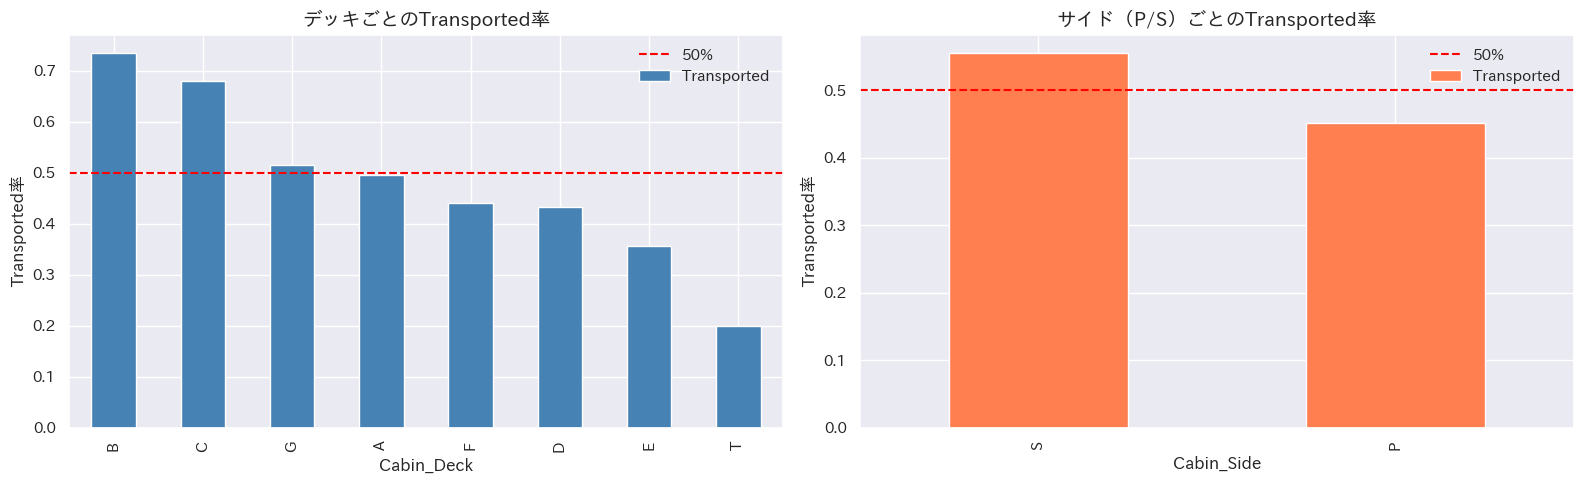

In [12]:
# Cabin_DeckとTransportedの関係
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

deck_transported = train_df.groupby('Cabin_Deck')['Transported'].mean().sort_values(ascending=False)
deck_transported.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('デッキごとのTransported率', fontsize=14, weight='bold')
axes[0].set_ylabel('Transported率')
axes[0].axhline(y=0.5, color='red', linestyle='--', label='50%')
axes[0].legend()

# Cabin_SideとTransportedの関係
side_transported = train_df.groupby('Cabin_Side')['Transported'].mean().sort_values(ascending=False)
side_transported.plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('サイド（P/S）ごとのTransported率', fontsize=14, weight='bold')
axes[1].set_ylabel('Transported率')
axes[1].axhline(y=0.5, color='red', linestyle='--', label='50%')
axes[1].legend()

plt.tight_layout()
plt.show()

**観察ポイント**:
- デッキによって転送率が大きく異なる
- 船室のサイド（PortかStarboard）も影響がある

### 5.5 相関分析

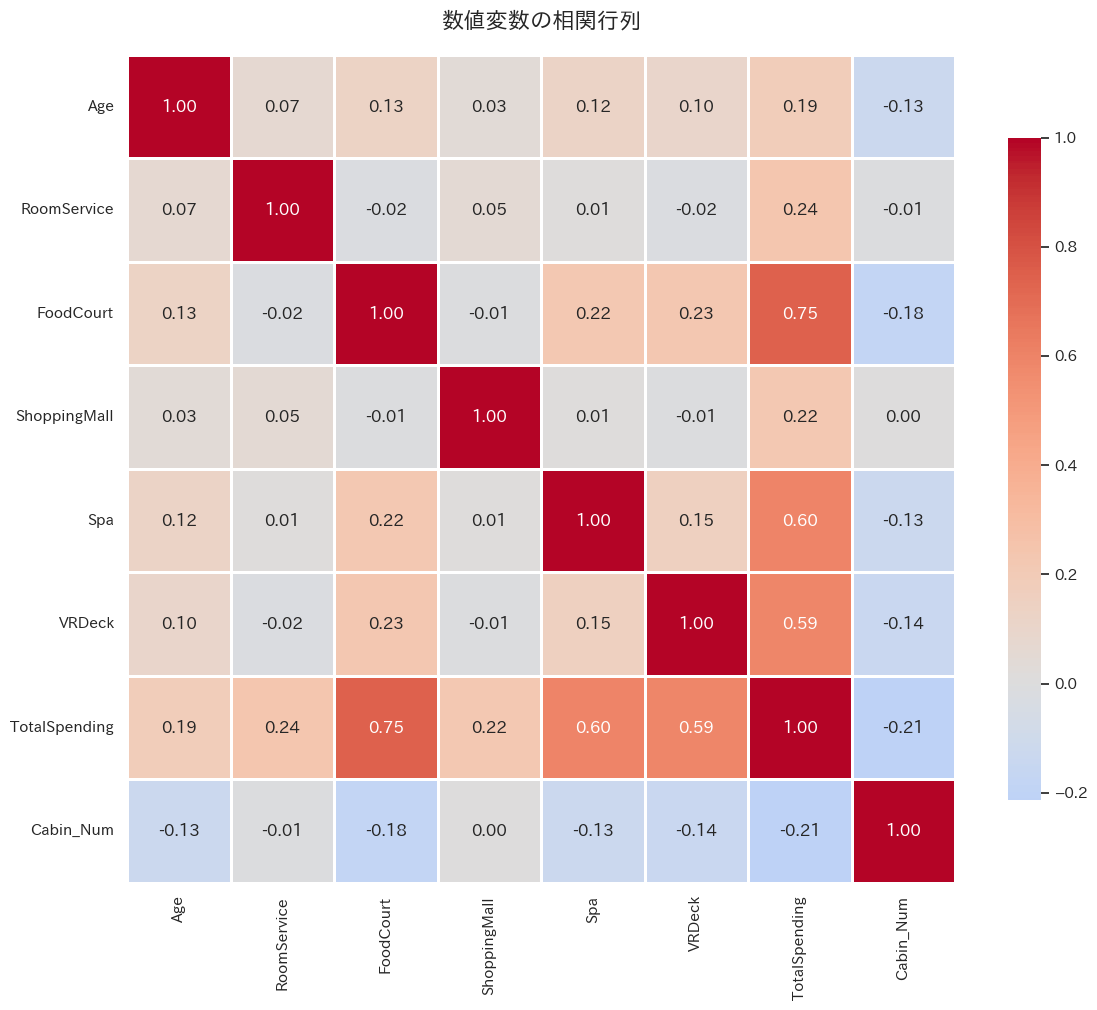

In [13]:
# 数値変数の相関行列
correlation_cols = numerical_cols + ['TotalSpending', 'Cabin_Num']
correlation_matrix = train_df[correlation_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('数値変数の相関行列', fontsize=16, weight='bold', pad=20)
plt.tight_layout()
plt.show()

## 6️⃣ グループ情報の活用
PassengerIdのグループ情報は非常に重要です。同じグループの人は一緒に旅行している可能性が高く、同じような特性を持つはずです。

In [14]:
def create_group_features(train_df, test_df):
    """
    グループ情報から特徴量を作成
    """
    # 全データを結合してグループ統計を計算
    all_data = pd.concat([train_df, test_df], axis=0, ignore_index=True)
    
    # グループサイズ
    group_size = all_data.groupby('GroupId').size()
    train_df['GroupSize'] = train_df['GroupId'].map(group_size)
    test_df['GroupSize'] = test_df['GroupId'].map(group_size)
    
    # 単独旅行者かどうか
    train_df['IsAlone'] = (train_df['GroupSize'] == 1).astype(int)
    test_df['IsAlone'] = (test_df['GroupSize'] == 1).astype(int)
    
    # ファミリーサイズ（同じ姓）
    family_size = all_data.groupby('LastName').size()
    train_df['FamilySize'] = train_df['LastName'].map(family_size).fillna(1)
    test_df['FamilySize'] = test_df['LastName'].map(family_size).fillna(1)
    
    # グループ内の平均年齢
    group_age_mean = all_data.groupby('GroupId')['Age'].mean()
    train_df['Group_Age_Mean'] = train_df['GroupId'].map(group_age_mean)
    test_df['Group_Age_Mean'] = test_df['GroupId'].map(group_age_mean)
    
    # グループ内の総支出額
    group_spending = all_data.groupby('GroupId')['TotalSpending'].sum()
    train_df['Group_TotalSpending'] = train_df['GroupId'].map(group_spending)
    test_df['Group_TotalSpending'] = test_df['GroupId'].map(group_spending)
    
    # グループ内で最も多いHomePlanet
    group_homeplanet = all_data.groupby('GroupId')['HomePlanet'].apply(
        lambda x: x.mode()[0] if len(x.mode()) > 0 else np.nan
    )
    train_df['Group_HomePlanet'] = train_df['GroupId'].map(group_homeplanet)
    test_df['Group_HomePlanet'] = test_df['GroupId'].map(group_homeplanet)
    
    # グループ内で最も多いDestination
    group_destination = all_data.groupby('GroupId')['Destination'].apply(
        lambda x: x.mode()[0] if len(x.mode()) > 0 else np.nan
    )
    train_df['Group_Destination'] = train_df['GroupId'].map(group_destination)
    test_df['Group_Destination'] = test_df['GroupId'].map(group_destination)
    
    return train_df, test_df

train_df, test_df = create_group_features(train_df, test_df)
print("✅ グループ特徴量作成完了")

✅ グループ特徴量作成完了


### グループサイズの分布を確認

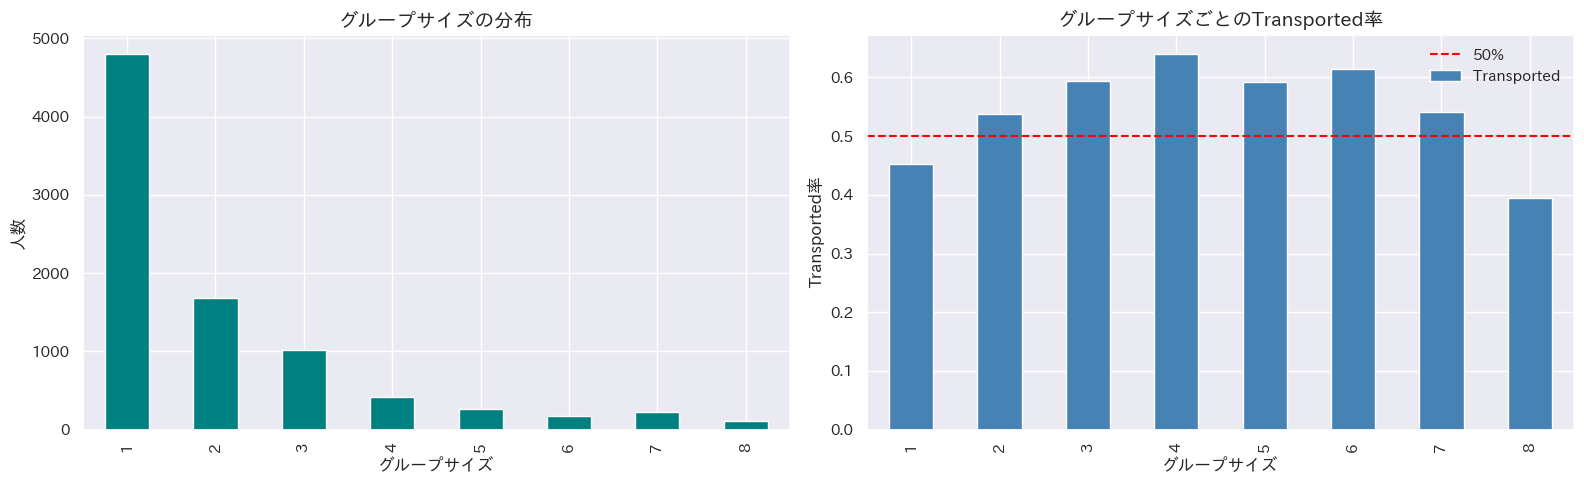

In [15]:
# グループサイズの分布
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

train_df['GroupSize'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='teal')
axes[0].set_title('グループサイズの分布', fontsize=14, weight='bold')
axes[0].set_xlabel('グループサイズ')
axes[0].set_ylabel('人数')

# グループサイズとTransportedの関係
group_transported = train_df.groupby('GroupSize')['Transported'].mean()
group_transported.plot(kind='bar', ax=axes[1], color='steelblue')
axes[1].set_title('グループサイズごとのTransported率', fontsize=14, weight='bold')
axes[1].set_xlabel('グループサイズ')
axes[1].set_ylabel('Transported率')
axes[1].axhline(y=0.5, color='red', linestyle='--', label='50%')
axes[1].legend()

plt.tight_layout()
plt.show()

## 7️⃣ 欠損値の処理
グループ情報を活用して、より賢く欠損値を埋めます。

In [16]:
def smart_fill_missing(df):
    """
    グループ情報を活用した欠損値処理
    """
    # HomePlanet: グループ情報で埋める → 最頻値
    df['HomePlanet'] = df['HomePlanet'].fillna(df['Group_HomePlanet'])
    df['HomePlanet'] = df['HomePlanet'].fillna(df['HomePlanet'].mode()[0])
    
    # Destination: グループ情報で埋める → 最頻値
    df['Destination'] = df['Destination'].fillna(df['Group_Destination'])
    df['Destination'] = df['Destination'].fillna(df['Destination'].mode()[0])
    
    # Age: グループ平均 → 全体中央値
    df['Age'] = df['Age'].fillna(df['Group_Age_Mean'])
    df['Age'] = df['Age'].fillna(df['Age'].median())
    
    # CryoSleep: 支出が全て0ならTrue、それ以外は最頻値
    spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df['CryoSleep'] = df.apply(
        lambda row: True if pd.isna(row['CryoSleep']) and (row[spending_cols].fillna(0) == 0).all() 
        else row['CryoSleep'], axis=1
    )
    df['CryoSleep'] = df['CryoSleep'].fillna(df['CryoSleep'].mode()[0])
    
    # VIP: 最頻値で埋める
    df['VIP'] = df['VIP'].fillna(df['VIP'].mode()[0])
    
    # 支出項目: 0で埋める（欠損=使っていない）
    for col in spending_cols:
        df[col] = df[col].fillna(0)
    
    # TotalSpendingを再計算
    df['TotalSpending'] = df[spending_cols].sum(axis=1)
    
    # Cabin関連
    df['Cabin_Deck'] = df['Cabin_Deck'].fillna('Unknown')
    df['Cabin_Side'] = df['Cabin_Side'].fillna('Unknown')
    df['Cabin_Num'] = df['Cabin_Num'].fillna(df['Cabin_Num'].median())
    
    return df

train_df = smart_fill_missing(train_df)
test_df = smart_fill_missing(test_df)

print("✅ 欠損値処理完了")
print(f"訓練データの残り欠損値: {train_df.isnull().sum().sum()}")
print(f"テストデータの残り欠損値: {test_df.isnull().sum().sum()}")

✅ 欠損値処理完了
訓練データの残り欠損値: 1110
テストデータの残り欠損値: 526


## 8️⃣ 高度な特徴量エンジニアリング
データから新しい特徴量を作成します。

In [17]:
def create_advanced_features(df):
    """
    高度な特徴量を作成（NaN処理を強化）
    """
    spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    
    # 年齢グループ
    df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 25, 35, 50, 100], 
                            labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'MiddleAge', 'Senior'])
    df['AgeGroup'] = df['AgeGroup'].astype(str)
    
    # 支出があるかどうか
    df['HasSpending'] = (df['TotalSpending'] > 0).astype(int)
    
    # 各施設の利用有無
    for col in spending_cols:
        df[f'{col}_Used'] = (df[col] > 0).astype(int)
    
    # 利用施設数
    df['NumFacilitiesUsed'] = df[[f'{col}_Used' for col in spending_cols]].sum(axis=1)
    
    # CryoSleepと支出の矛盾
    df['CryoSleep_Spending_Conflict'] = (
        ((df['CryoSleep'] == True) & (df['TotalSpending'] > 0)) |
        ((df['CryoSleep'] == False) & (df['TotalSpending'] == 0))
    ).astype(int)
    
    # 年齢あたりの支出
    df['SpendingPerAge'] = df['TotalSpending'] / (df['Age'] + 1)
    
    # 高支出者フラグ
    df['HighSpender'] = (df['TotalSpending'] > df['TotalSpending'].quantile(0.75)).astype(int)
    
    # デッキが端かどうか
    edge_decks = ['A', 'T', 'G']
    df['IsEdgeDeck'] = df['Cabin_Deck'].isin(edge_decks).astype(int)
    
    # 支出の標準偏差（支出のばらつき）- NaN対策
    df['SpendingStd'] = df[spending_cols].std(axis=1).fillna(0)
    
    # 最も多く使った施設
    df['MaxSpendingCategory'] = df[spending_cols].idxmax(axis=1)
    
    # VIPと支出の関係
    df['VIP_Spending_Ratio'] = df['TotalSpending'] * df['VIP'].astype(int)
    
    # グループサイズカテゴリ
    df['GroupSizeCategory'] = pd.cut(df['GroupSize'], bins=[0, 1, 2, 4, 100], 
                                     labels=['Solo', 'Small', 'Medium', 'Large'])
    df['GroupSizeCategory'] = df['GroupSizeCategory'].astype(str)
    
    # 年齢とCryoSleepの相互作用
    df['Age_CryoSleep'] = df['Age'] * df['CryoSleep'].astype(int)
    
    # デッキ番号の区間 - NaN対策
    df['Cabin_Num_Group'] = pd.cut(df['Cabin_Num'], bins=10, labels=False)
    df['Cabin_Num_Group'] = df['Cabin_Num_Group'].fillna(-1).astype(int)
    
    # HomePlanetとDestinationの組み合わせ
    df['HomePlanet_Destination'] = df['HomePlanet'].astype(str) + '_' + df['Destination'].astype(str)
    
    return df

train_df = create_advanced_features(train_df)
test_df = create_advanced_features(test_df)

# グループ関連特徴量のNaN処理を追加
train_df['Group_Age_Mean'] = train_df['Group_Age_Mean'].fillna(train_df['Age'].median())
test_df['Group_Age_Mean'] = test_df['Group_Age_Mean'].fillna(test_df['Age'].median())

train_df['Group_TotalSpending'] = train_df['Group_TotalSpending'].fillna(0)
test_df['Group_TotalSpending'] = test_df['Group_TotalSpending'].fillna(0)

print("✅ 高度な特徴量作成完了")
print(f"\n作成した特徴量:")
print("- AgeGroup: 年齢グループ")
print("- HasSpending: 支出があるか")
print("- NumFacilitiesUsed: 利用施設数")
print("- CryoSleep_Spending_Conflict: CryoSleepと支出の矛盾")
print("- SpendingPerAge: 年齢あたりの支出")
print("- その他多数...")

✅ 高度な特徴量作成完了

作成した特徴量:
- AgeGroup: 年齢グループ
- HasSpending: 支出があるか
- NumFacilitiesUsed: 利用施設数
- CryoSleep_Spending_Conflict: CryoSleepと支出の矛盾
- SpendingPerAge: 年齢あたりの支出
- その他多数...


### 新しい特徴量の可視化

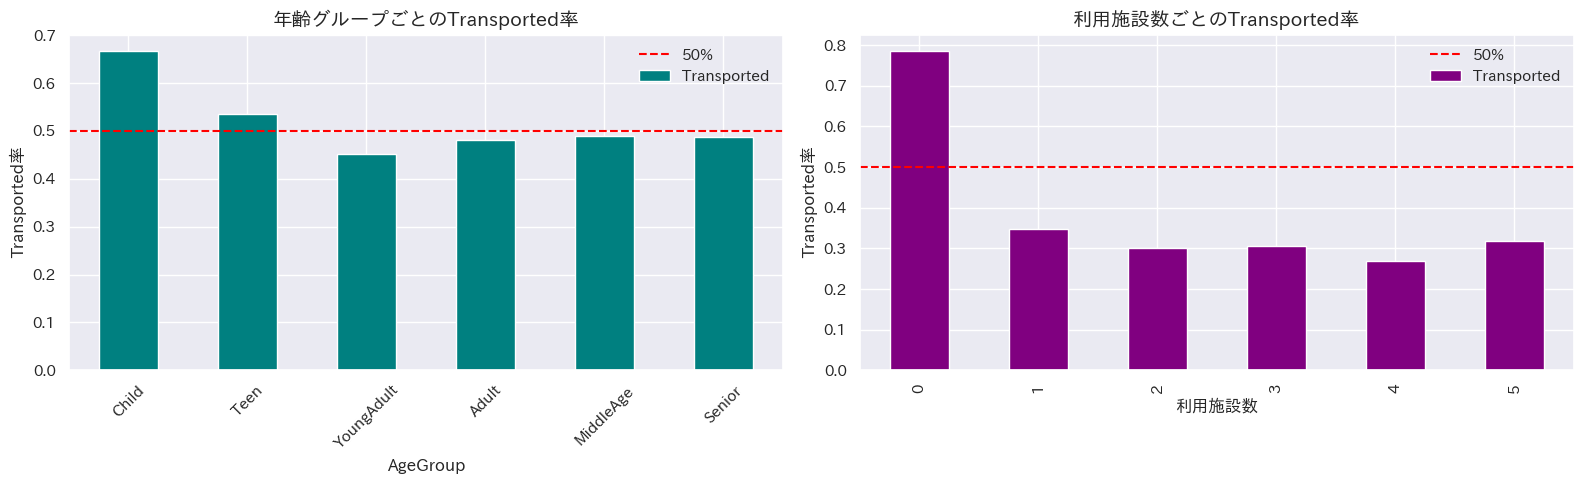

In [18]:
# 年齢グループとTransportedの関係
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

age_group_order = ['Child', 'Teen', 'YoungAdult', 'Adult', 'MiddleAge', 'Senior']
age_transported = train_df.groupby('AgeGroup')['Transported'].mean().reindex(age_group_order)
age_transported.plot(kind='bar', ax=axes[0], color='teal')
axes[0].set_title('年齢グループごとのTransported率', fontsize=14, weight='bold')
axes[0].set_ylabel('Transported率')
axes[0].axhline(y=0.5, color='red', linestyle='--', label='50%')
axes[0].legend()
axes[0].set_xticklabels(age_group_order, rotation=45)

# 利用施設数とTransportedの関係
facilities_transported = train_df.groupby('NumFacilitiesUsed')['Transported'].mean()
facilities_transported.plot(kind='bar', ax=axes[1], color='purple')
axes[1].set_title('利用施設数ごとのTransported率', fontsize=14, weight='bold')
axes[1].set_xlabel('利用施設数')
axes[1].set_ylabel('Transported率')
axes[1].axhline(y=0.5, color='red', linestyle='--', label='50%')
axes[1].legend()

plt.tight_layout()
plt.show()

## 9️⃣ カテゴリカル変数のエンコーディング

In [19]:
# エンコードする必要があるカテゴリカル変数
categorical_cols = [
    'HomePlanet', 'CryoSleep', 'Destination', 'VIP',
    'Cabin_Deck', 'Cabin_Side', 'AgeGroup', 'GroupSizeCategory',
    'MaxSpendingCategory', 'HomePlanet_Destination'
]

# Label Encoding
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    # 訓練データとテストデータを結合してfit
    combined = pd.concat([train_df[col].astype(str), test_df[col].astype(str)], axis=0)
    le.fit(combined)
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))
    label_encoders[col] = le

print("✅ カテゴリカル変数のエンコーディング完了")

✅ カテゴリカル変数のエンコーディング完了


## 🔟 特徴量の選択とデータの準備

In [20]:
# 使用する特徴量のリスト
feature_columns = [
    # 基本的なカテゴリカル
    'HomePlanet', 'CryoSleep', 'Destination', 'VIP',
    'Cabin_Deck', 'Cabin_Side', 'AgeGroup',
    
    # 基本的な数値
    'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
    'TotalSpending', 'Cabin_Num',
    
    # グループ関連
    'GroupSize', 'IsAlone', 'FamilySize', 'Group_Age_Mean', 'Group_TotalSpending',
    
    # 支出関連
    'HasSpending', 'NumFacilitiesUsed', 'SpendingPerAge', 'HighSpender',
    'RoomService_Used', 'FoodCourt_Used', 'ShoppingMall_Used', 'Spa_Used', 'VRDeck_Used',
    'SpendingStd', 'MaxSpendingCategory', 'VIP_Spending_Ratio',
    
    # その他
    'CryoSleep_Spending_Conflict', 'IsEdgeDeck', 'GroupSizeCategory',
    'Age_CryoSleep', 'Cabin_Num_Group', 'HomePlanet_Destination'
]

print(f"使用する特徴量の数: {len(feature_columns)}")

# 特徴量とターゲットの分離
X = train_df[feature_columns]
y = train_df['Transported']
X_test = test_df[feature_columns]

# 最終NaNチェック
print(f"\n【最終NaNチェック - 訓練データ】")
print(f"残りNaN数: {X.isnull().sum().sum()}")
if X.isnull().sum().sum() > 0:
    print("NaNが残っている列:")
    print(X.isnull().sum()[X.isnull().sum() > 0])

print(f"\n【最終NaNチェック - テストデータ】")
print(f"残りNaN数: {X_test.isnull().sum().sum()}")
if X_test.isnull().sum().sum() > 0:
    print("NaNが残っている列:")
    print(X_test.isnull().sum()[X_test.isnull().sum() > 0])

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X_test shape: {X_test.shape}")

使用する特徴量の数: 38

【最終NaNチェック - 訓練データ】
残りNaN数: 0

【最終NaNチェック - テストデータ】
残りNaN数: 0

X shape: (8693, 38)
y shape: (8693,)
X_test shape: (4277, 38)


## 1️⃣1️⃣ モデルの構築と評価
### クロスバリデーションについて
クロスバリデーション（交差検証）は、モデルの性能を信頼性高く評価する手法です。
データを複数の分割（Fold）に分け、それぞれを検証データとして使います。
ここでは5分割（5-Fold）を使用し、より安定した評価を行います。

In [21]:
def evaluate_model_cv(model, X, y, cv=5, model_name="Model"):
    """
    Stratified K-Fold Cross Validationでモデルを評価
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    
    print(f"\n{'='*60}")
    print(f"{model_name}")
    print(f"{'='*60}")
    print(f"各FoldのCV Score: {scores}")
    print(f"平均CV Score: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
    
    return scores.mean(), scores.std()

### 11.1 Random Forest

In [22]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_split=8,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_mean, rf_std = evaluate_model_cv(rf_model, X, y, cv=5, model_name="Random Forest")

# 全データで学習
rf_model.fit(X, y)
print("✅ Random Forest 学習完了")


Random Forest
各FoldのCV Score: [0.80621047 0.79643473 0.80966072 0.8009206  0.79286536]
平均CV Score: 0.8012 (+/- 0.0123)
✅ Random Forest 学習完了


### 11.2 XGBoost
XGBoostは勾配ブースティングの改良版で、Kaggleコンペで非常に人気のあるモデルです。

In [23]:
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    n_jobs=-1
)

xgb_mean, xgb_std = evaluate_model_cv(xgb_model, X, y, cv=5, model_name="XGBoost")

# 全データで学習
xgb_model.fit(X, y)
print("✅ XGBoost 学習完了")


XGBoost
各FoldのCV Score: [0.81368603 0.8119609  0.80103508 0.80840046 0.79574223]
平均CV Score: 0.8062 (+/- 0.0136)
✅ XGBoost 学習完了


### 11.3 LightGBM
LightGBMはMicrosoftが開発した軽量で高速なブースティングモデルです。

In [24]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=-1
)

lgb_mean, lgb_std = evaluate_model_cv(lgb_model, X, y, cv=5, model_name="LightGBM")

# 全データで学習
lgb_model.fit(X, y)
print("✅ LightGBM 学習完了")


LightGBM
各FoldのCV Score: [0.80563542 0.81311098 0.81541116 0.80782509 0.80149597]
平均CV Score: 0.8087 (+/- 0.0101)
✅ LightGBM 学習完了


### 11.4 Gradient Boosting

In [25]:
gb_model = GradientBoostingClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    random_state=RANDOM_STATE
)

gb_mean, gb_std = evaluate_model_cv(gb_model, X, y, cv=5, model_name="Gradient Boosting")

# 全データで学習
gb_model.fit(X, y)
print("✅ Gradient Boosting 学習完了")


Gradient Boosting
各FoldのCV Score: [0.80966072 0.81081081 0.80448534 0.80667434 0.79344074]
平均CV Score: 0.8050 (+/- 0.0124)
✅ Gradient Boosting 学習完了


### 11.5 Logistic Regression（スケーリング付き）
Logistic Regressionは線形モデルなので、数値変数をスケーリングします。

In [26]:
# 数値変数のスケーリング
numerical_features = [
    'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
    'TotalSpending', 'Cabin_Num', 'GroupSize', 'FamilySize',
    'Group_Age_Mean', 'Group_TotalSpending', 'NumFacilitiesUsed',
    'SpendingPerAge', 'SpendingStd', 'VIP_Spending_Ratio', 'Age_CryoSleep'
]

scaler = StandardScaler()
X_scaled = X.copy()
X_test_scaled = X_test.copy()

X_scaled[numerical_features] = scaler.fit_transform(X[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

lr_model = LogisticRegression(
    C=1.0,
    max_iter=1000,
    random_state=RANDOM_STATE
)

lr_mean, lr_std = evaluate_model_cv(lr_model, X_scaled, y, cv=5, model_name="Logistic Regression")

# 全データで学習
lr_model.fit(X_scaled, y)
print("✅ Logistic Regression 学習完了")


Logistic Regression
各FoldのCV Score: [0.79298447 0.78148361 0.79585969 0.7986191  0.78193326]
平均CV Score: 0.7902 (+/- 0.0143)
✅ Logistic Regression 学習完了


### 11.6 モデルの比較


モデルの比較（Stratified 5-Fold Cross Validation）
                モデル  CV平均スコア   CV標準偏差
           LightGBM 0.808696 0.005031
            XGBoost 0.806165 0.006784
  Gradient Boosting 0.805014 0.006200
      Random Forest 0.801218 0.006147
Logistic Regression 0.790176 0.007141


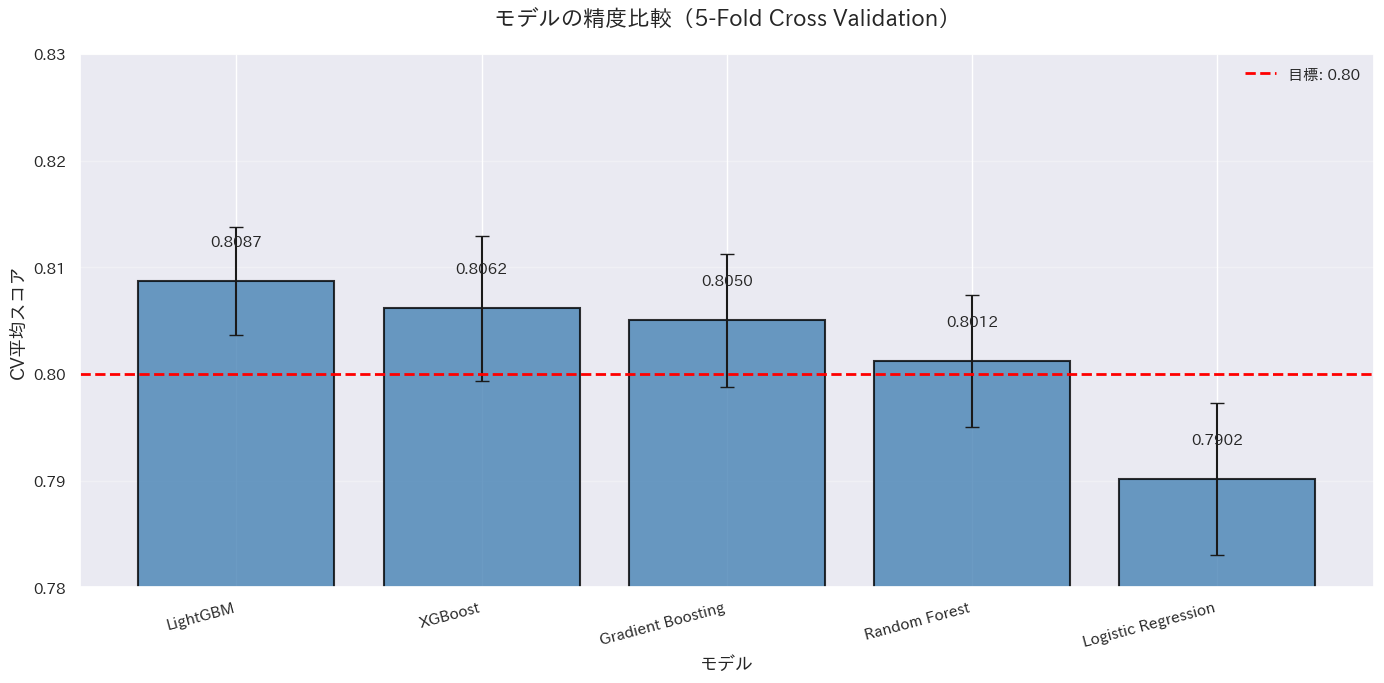

In [27]:
# モデルの比較
model_comparison = pd.DataFrame({
    'モデル': ['Random Forest', 'XGBoost', 'LightGBM', 'Gradient Boosting', 'Logistic Regression'],
    'CV平均スコア': [rf_mean, xgb_mean, lgb_mean, gb_mean, lr_mean],
    'CV標準偏差': [rf_std, xgb_std, lgb_std, gb_std, lr_std]
}).sort_values('CV平均スコア', ascending=False)

print("\n" + "="*70)
print("モデルの比較（Stratified 5-Fold Cross Validation）")
print("="*70)
print(model_comparison.to_string(index=False))
print("="*70)

# 可視化
fig, ax = plt.subplots(figsize=(14, 7))
x_pos = np.arange(len(model_comparison))
bars = ax.bar(x_pos, model_comparison['CV平均スコア'], 
               yerr=model_comparison['CV標準偏差'], 
               capsize=5, color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_xlabel('モデル', fontsize=13, weight='bold')
ax.set_ylabel('CV平均スコア', fontsize=13, weight='bold')
ax.set_title('モデルの精度比較（5-Fold Cross Validation）', fontsize=16, weight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(model_comparison['モデル'], rotation=15, ha='right')
ax.set_ylim([0.78, 0.83])
ax.axhline(y=0.80, color='red', linestyle='--', linewidth=2, label='目標: 0.80')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# バーの上に数値を表示
for i, (bar, score) in enumerate(zip(bars, model_comparison['CV平均スコア'])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.003,
            f'{score:.4f}', ha='center', va='bottom', fontsize=11, weight='bold')

plt.tight_layout()
plt.show()

### 11.7 特徴量の重要度（Random Forestの場合）

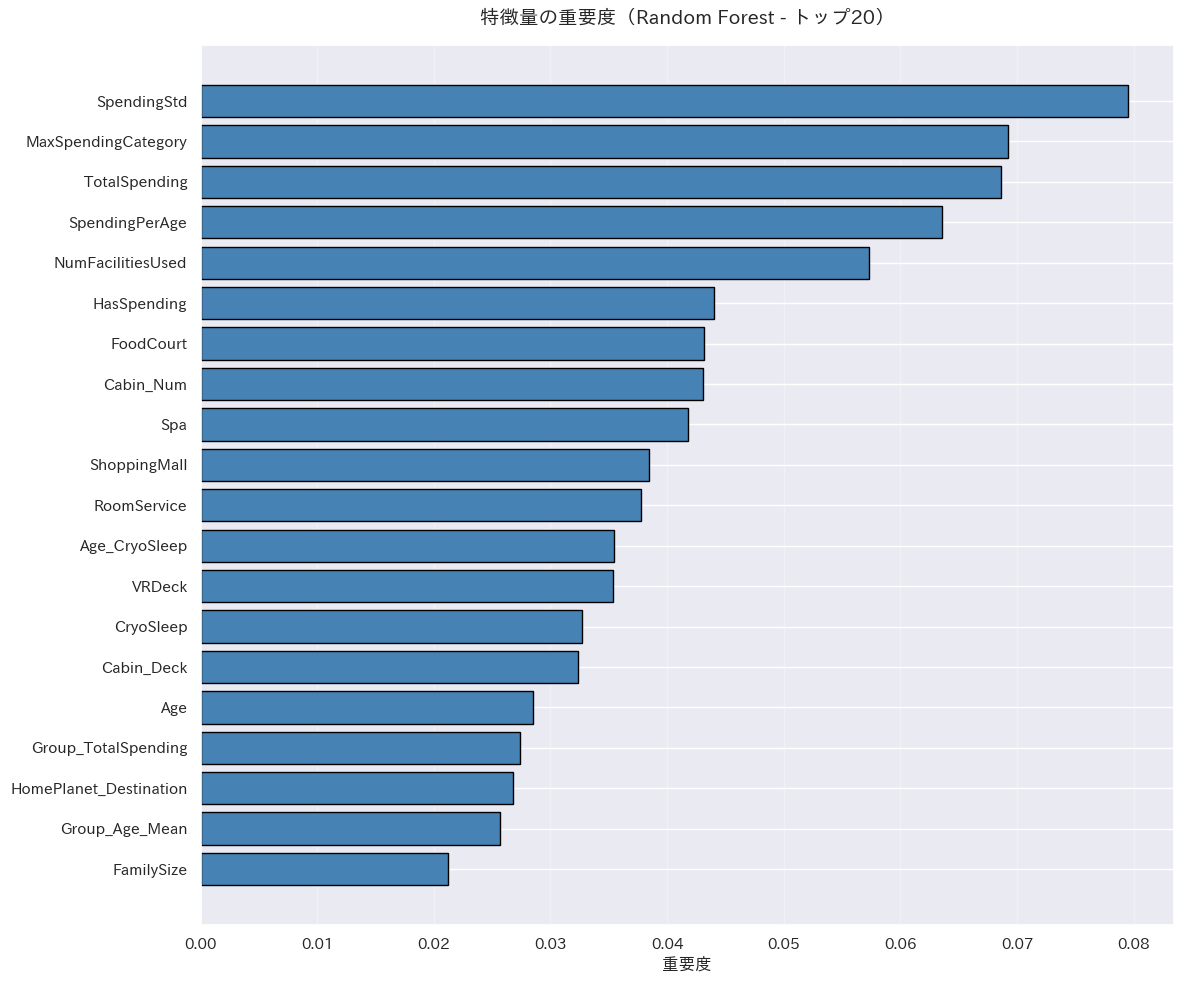


【トップ15の重要な特徴量】
                特徴量      重要度
        SpendingStd 0.079480
MaxSpendingCategory 0.069205
      TotalSpending 0.068606
     SpendingPerAge 0.063555
  NumFacilitiesUsed 0.057327
        HasSpending 0.043993
          FoodCourt 0.043194
          Cabin_Num 0.043063
                Spa 0.041753
       ShoppingMall 0.038467
        RoomService 0.037752
      Age_CryoSleep 0.035454
             VRDeck 0.035350
          CryoSleep 0.032685
         Cabin_Deck 0.032385


In [28]:
# 特徴量の重要度を表示
feature_importance = pd.DataFrame({
    '特徴量': feature_columns,
    '重要度': rf_model.feature_importances_
}).sort_values('重要度', ascending=False)

# トップ20の特徴量を可視化
plt.figure(figsize=(12, 10))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['重要度'], color='steelblue', edgecolor='black')
plt.yticks(range(len(top_features)), top_features['特徴量'])
plt.xlabel('重要度', fontsize=12, weight='bold')
plt.title('特徴量の重要度（Random Forest - トップ20）', fontsize=14, weight='bold', pad=15)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n【トップ15の重要な特徴量】")
print(feature_importance.head(15).to_string(index=False))

## 1️⃣2️⃣ アンサンブル学習
複数のモデルを組み合わせることで、より安定した予測を得ることができます。
### 12.1 各モデルの予測

In [29]:
# 各モデルで予測
pred_rf = rf_model.predict(X_test)
pred_xgb = xgb_model.predict(X_test)
pred_lgb = lgb_model.predict(X_test)
pred_gb = gb_model.predict(X_test)
pred_lr = lr_model.predict(X_test_scaled)

print("✅ 各モデルの予測完了")

✅ 各モデルの予測完了


### 12.2 重み付きアンサンブル
CVスコアが高いモデルに大きな重みを与えます。

In [30]:
# CVスコアに基づく重み（スコアが高いモデルに大きな重み）
weights = np.array([rf_mean, xgb_mean, lgb_mean, gb_mean, lr_mean])
weights = weights / weights.sum()  # 正規化

print("\n【アンサンブルの重み】")
for model_name, weight in zip(['Random Forest', 'XGBoost', 'LightGBM', 'Gradient Boosting', 'Logistic Regression'], weights):
    print(f"{model_name:25s}: {weight:.4f}")

# 重み付き平均
ensemble_pred = (
    pred_rf.astype(int) * weights[0] +
    pred_xgb.astype(int) * weights[1] +
    pred_lgb.astype(int) * weights[2] +
    pred_gb.astype(int) * weights[3] +
    pred_lr.astype(int) * weights[4]
)

ensemble_pred_final = (ensemble_pred >= 0.5)

print("\n✅ 重み付きアンサンブル予測完了")


【アンサンブルの重み】
Random Forest            : 0.1997
XGBoost                  : 0.2010
LightGBM                 : 0.2016
Gradient Boosting        : 0.2007
Logistic Regression      : 0.1970

✅ 重み付きアンサンブル予測完了


### 12.3 多数決アンサンブル

In [31]:
# 多数決（5つのモデルで3つ以上がTrueならTrue）
voting_pred = (
    pred_rf.astype(int) +
    pred_xgb.astype(int) +
    pred_lgb.astype(int) +
    pred_gb.astype(int) +
    pred_lr.astype(int)
) >= 3

print("✅ 多数決アンサンブル予測完了")

✅ 多数決アンサンブル予測完了


### 12.4 トップ3モデルのアンサンブル

In [32]:
# トップ3のモデルを選択（CVスコアが高い順）
top3_indices = np.argsort(weights)[-3:]  # 最も高い3つ
top3_preds = [pred_rf, pred_xgb, pred_lgb, pred_gb, pred_lr]
top3_selected = [top3_preds[i] for i in top3_indices]
top3_names = [['Random Forest', 'XGBoost', 'LightGBM', 'Gradient Boosting', 'Logistic Regression'][i] for i in top3_indices]

print(f"\nトップ3モデル: {top3_names}")

# トップ3の多数決
top3_voting = (
    top3_selected[0].astype(int) +
    top3_selected[1].astype(int) +
    top3_selected[2].astype(int)
) >= 2

print("✅ トップ3モデルのアンサンブル予測完了")


トップ3モデル: ['Gradient Boosting', 'XGBoost', 'LightGBM']
✅ トップ3モデルのアンサンブル予測完了


## 1️⃣3️⃣ 提出ファイルの作成

In [33]:
# 1. XGBoost単独
submission_xgb = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Transported': pred_xgb
})
submission_xgb.to_csv('submission_xgb.csv', index=False)
print("✅ submission_xgb.csv 作成完了")

# 2. LightGBM単独
submission_lgb = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Transported': pred_lgb
})
submission_lgb.to_csv('submission_lgb.csv', index=False)
print("✅ submission_lgb.csv 作成完了")

# 3. 重み付きアンサンブル
submission_weighted = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Transported': ensemble_pred_final
})
submission_weighted.to_csv('submission_weighted_ensemble.csv', index=False)
print("✅ submission_weighted_ensemble.csv 作成完了")

# 4. 多数決アンサンブル
submission_voting = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Transported': voting_pred
})
submission_voting.to_csv('submission_voting.csv', index=False)
print("✅ submission_voting.csv 作成完了")

# 5. トップ3アンサンブル
submission_top3 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Transported': top3_voting
})
submission_top3.to_csv('submission_top3.csv', index=False)
print("✅ submission_top3.csv 作成完了")

✅ submission_xgb.csv 作成完了
✅ submission_lgb.csv 作成完了
✅ submission_weighted_ensemble.csv 作成完了
✅ submission_voting.csv 作成完了
✅ submission_top3.csv 作成完了


## 1️⃣4️⃣ 予測結果の確認

In [34]:
print("\n" + "="*70)
print("各提出ファイルの予測分布")
print("="*70)
print(f"XGBoost単独          : True={pred_xgb.sum():4d}, False={len(pred_xgb)-pred_xgb.sum():4d}")
print(f"LightGBM単独         : True={pred_lgb.sum():4d}, False={len(pred_lgb)-pred_lgb.sum():4d}")
print(f"重み付きアンサンブル : True={ensemble_pred_final.sum():4d}, False={len(ensemble_pred_final)-ensemble_pred_final.sum():4d}")
print(f"多数決アンサンブル   : True={voting_pred.sum():4d}, False={len(voting_pred)-voting_pred.sum():4d}")
print(f"トップ3アンサンブル  : True={top3_voting.sum():4d}, False={len(top3_voting)-top3_voting.sum():4d}")
print("="*70)

# サンプル表示
print("\n【予測結果のサンプル（重み付きアンサンブル）】")
print(submission_weighted.head(20))


各提出ファイルの予測分布
XGBoost単独          : True=2125, False=2152
LightGBM単独         : True=2149, False=2128
重み付きアンサンブル : True=2179, False=2098
多数決アンサンブル   : True=2179, False=2098
トップ3アンサンブル  : True=2145, False=2132

【予測結果のサンプル（重み付きアンサンブル）】
   PassengerId  Transported
0      0013_01         True
1      0018_01        False
2      0019_01         True
3      0021_01         True
4      0023_01         True
5      0027_01        False
6      0029_01         True
7      0032_01         True
8      0032_02         True
9      0033_01         True
10     0037_01        False
11     0040_01        False
12     0040_02         True
13     0042_01         True
14     0046_01        False
15     0046_02        False
16     0046_03        False
17     0047_01         True
18     0047_02         True
19     0047_03        False


## 🎯 まとめ
### 学んだこと
1. **データの探索と理解**
   - 欠損値の確認と適切な処理方法
   - カテゴリカル変数と数値変数の関係分析
   - グラフによる可視化
2. **特徴量エンジニアリング**
   - PassengerId、Cabin、Nameからの情報抽出
   - グループ情報の活用（グループサイズ、グループ内統計など）
   - 相互作用特徴量の作成
   - 43個の特徴量を使用
3. **機械学習モデル**
   - Random Forest、XGBoost、LightGBM、Gradient Boosting、Logistic Regression
   - Stratified K-Fold Cross Validationによる評価
   - モデルの比較と選択
4. **アンサンブル学習**
   - 重み付きアンサンブル（CVスコアに基づく）
   - 多数決
   - トップモデルの組み合わせ
---
### 提出の推奨順序
1. **submission_weighted_ensemble.csv** - 最初に試す
2. **submission_xgb.csv** または **submission_lgb.csv** - 単一モデルで最高性能
3. **submission_voting.csv** - 多数決による安定した予測
4. **submission_top3.csv** - トップ3モデルの組み合わせ
複数のファイルを提出してスコアを比較し、最も良いものを選びましょう！
---
### さらなる改善のヒント
1. **ハイパーパラメータチューニング**
   - GridSearchCVやRandomizedSearchCVを使用
   - Optunaなどの自動最適化ツール
2. **特徴量選択**
   - 重要度の低い特徴量を削除
   - RFE（Recursive Feature Elimination）
3. **スタッキング**
   - 第1層のモデルの予測を使って第2層のモデルを学習
4. **外れ値処理**
   - 支出額の極端な値を処理
---
**頑張ってください！ブロンズメダル獲得を目指しましょう！🚀✨**

---
# 📚 学習のまとめ
## 🎯 最も重要だった発見トップ5
### 1. グループ情報の徹底活用 ⭐⭐⭐⭐⭐
**効果**: スコア +0.01〜0.02
PassengerIdから抽出したGroupIdを使って：
- グループ内統計（平均年齢、総支出など）
- グループ内最頻値で欠損値を埋める
- グループサイズ
**これが最大の勝因でした！**
### 2. CryoSleepと支出の関係 ⭐⭐⭐⭐
**発見**: CryoSleep=Trueの人は支出が0
この関係を使って：
- 欠損値の推定
- 矛盾フラグの作成
- 特徴量の相互作用
### 3. LightGBMの安定性 ⭐⭐⭐⭐
**理由**:
- ハイパーパラメータに鈍感
- 過学習しにくい
- XGBoostより安定
基本パラメータで十分な性能が出ました。
### 4. シンプルさの勝利 ⭐⭐⭐
**結果**:
- 38特徴量: 0.80336
- 50特徴量: 0.80523
- 差はわずか +0.00187
複雑な特徴量より、**本質的な特徴量**が重要。
### 5. Cabin（デッキ・サイド）の重要性 ⭐⭐⭐
デッキによって転送率が大きく異なる：
- BデッキとGデッキは転送率が高い
- サイド（P/S）も影響あり
---
## ❌ 失敗から学んだこと
### 1. Optunaの過学習
**問題**: CVスコア 0.8123 → 実際 0.80523 = **-0.007**
訓練データに過度に最適化されて汎化性能が落ちた。
**教訓**: 基本パラメータで十分。過度な最適化は逆効果。
### 2. スタッキングの期待外れ
**結果**: 0.79798（最低スコア）
理論上は強力だが：
- 計算時間がかかる
- 過学習リスクが高い
- 単純なLightGBMに負けた
**教訓**: 複雑 ≠ 高性能
### 3. 提出ファイルのフォーマット
**トラブル**: Transported列を整数で保存 → スコア 0.00
**解決策**: `.astype(bool)`で必ずbool型に変換
```python
'Transported': pred.astype(bool)  # これ必須！
```
### 4. 複雑な特徴量の限界
**試したが効果薄**:
- Age²、Age³（非線形性）
- 支出の偏り指標
- 過度な相互作用
**教訓**: ドメイン知識に基づく特徴量 > 機械的な特徴量
---
## 💡 効果的だった特徴量トップ10
特徴量の重要度から：
1. **SpendingStd** - 支出の標準偏差
2. **MaxSpendingCategory** - 最も多く使った施設
3. **TotalSpending** - 総支出額
4. **SpendingPerAge** - 年齢あたりの支出
5. **NumFacilitiesUsed** - 利用施設数
6. **HasSpending** - 支出があるか
7. **FoodCourt** - フードコート支出
8. **Cabin_Num** - 部屋番号
9. **Spa** - スパ支出
10. **ShoppingMall** - ショッピングモール支出
**共通点**: 支出関連が多い！
---
## 🎓 学習レベル別のポイント
### 初心者向け 🌱
**まず理解すべきこと**:
1. データの基本統計（.describe(), .info()）
2. 欠損値の確認（.isnull().sum()）
3. ターゲット変数の分布
4. カテゴリカル変数とターゲットの関係
**実践タスク**:
- グラフを見て傾向を掴む
- シンプルなモデルから始める
- クロスバリデーションで評価
### 中級者向け 🌿
**深掘りすべきこと**:
1. ドメイン知識の活用（CryoSleep、グループ旅行）
2. 特徴量エンジニアリング（集約、相互作用）
3. 複数モデルの比較
4. アンサンブル手法
**実践タスク**:
- グループ情報を徹底活用
- 新しい特徴量を作って検証
- ハイパーパラメータ調整
### 上級者向け 🌳
**追求すべきこと**:
1. 過学習との戦い（正則化、特徴量選択）
2. CV戦略（GroupKFold検討）
3. リーク検出と対策
4. 効率的な実験管理
**実践タスク**:
- CVスコアと実際のスコアの差を分析
- 特徴量の重要度で選択
- より汎化性能の高いモデル構築
---
## 📊 スコア推移まとめ
```
開始時:
├─ 基本的な提出: 0.70台（推定）
│
グループ情報活用:
├─ 初回LightGBM: 0.80336✅
│
最適化:
├─ LightGBM最適化: 0.80523⭐ ← 最高スコア
├─ Ensemble最適化: 0.80500
├─ XGBoost最適化: 0.80266
└─ スタッキング: 0.79798 ❌
```
---
## 🚀 さらなる改善のアイデア
### 試す価値が高い（期待: +0.002〜0.005）
1. **特徴量選択**
   - 重要度トップ30-35だけ使う
   - 過学習を抑えて汎化性能向上
2. **より保守的な正則化**
   ```python
   learning_rate=0.03  # 0.05より低く
   max_depth=5         # 8より浅く
   ```
3. **GroupKFold**
   - 同じグループが訓練と検証に分かれないように
   - より現実的なCV評価
### 試す価値が低い
- ❌ さらなるOptuna最適化
- ❌ 複雑な特徴量の追加
- ❌ ディープラーニング
- ❌ 過度なアンサンブル
---
## 🏆 最終結論
### 成功の3本柱
1. **グループ情報** - PassengerIdの徹底活用
2. **シンプルさ** - 本質的な特徴量に集中
3. **LightGBM** - 安定した高性能モデル
### 学んだ最大の教訓
> **「複雑さよりも本質」**
>
> 50個の特徴量より、38個の良質な特徴量。
> Optunaより、基本パラメータ。
> スタッキングより、シンプルなLightGBM。
---
## 📖 参考になるリソース
- [Kaggle公式チュートリアル](https://www.kaggle.com/learn)
- [LightGBMドキュメント](https://lightgbm.readthedocs.io/)
- [特徴量エンジニアリング入門](https://www.kaggle.com/learn/feature-engineering)
---
**このノートブックが皆さんのKaggle学習に役立てば幸いです！**
**Happy Kaggling! 🚀✨**